## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from random import sample

from itertools import chain

import scipy
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import sklearn.model_selection as skl

import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_df = pd.read_csv('/data/Data_Entry_2017.csv')

#filter age > 95
all_df['Patient Age'] = all_df['Patient Age'].astype(int)
all_df = all_df[all_df['Patient Age'] >= 20]
all_df = all_df[all_df['Patient Age'] <= 80]


all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_df.shape[0])
all_df['path'] = all_df['Image Index'].map(all_image_paths.get)
all_df.sample(3)

Scans found: 112120 , Total Headers 104399


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105207,00028243_000.png,Infiltration,0,28243,63,M,PA,2992,2991,0.143,0.143,NaN,/data/images_012/images/00028243_000.png
72601,00017897_000.png,No Finding,0,17897,46,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017897_000.png
96919,00025555_000.png,No Finding,0,25555,51,M,PA,3056,2544,0.139,0.139,NaN,/data/images_011/images/00025555_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_df[c_label] = all_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_df['Number of Diseases'] = 0

all_df['Number of Diseases'] = all_df.apply(
    lambda row: 0 if row['Finding Labels'] == 'No Finding' else len(row['Finding Labels'].split('|'))
    , axis=1)

all_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_df['pneumonia_class'] = None

all_df['pneumonia_class'] = all_df.apply(
    lambda row: "0" if row['Pneumonia'] == 0 else "1"
    , axis=1)

all_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class
98854,00026134_002.png,Mass|Nodule,2,26134,52,F,PA,2546,2781,0.143,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,0
90776,00022604_013.png,Infiltration,13,22604,26,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
109400,00029762_002.png,Effusion|Infiltration,2,29762,49,F,AP,2544,3056,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
51471,00013002_013.png,No Finding,13,13002,67,F,PA,2630,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
48749,00012364_016.png,No Finding,16,12364,52,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
51924,00013111_057.png,Emphysema,57,13111,20,M,PA,2562,2290,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
27843,00007246_001.png,Nodule,1,7246,55,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
97058,00025602_001.png,Atelectasis,1,25602,25,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
81397,00019994_005.png,Atelectasis,5,19994,62,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
44797,00011514_022.png,Infiltration,22,11514,46,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [5]:
all_df['pneumonia_class'].value_counts()

0    103105
1      1294
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [121]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])

    
    
    #Condition 1 - To have EQUAL amount of positive and negative cases of Pneumonia in Training¶
    p_inds = train_data[train_data['pneumonia_class']=="1"].index.tolist()
    np_inds = train_data[train_data['pneumonia_class']=="0"].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]

    #Condition 2 - To have positive cases of Pneumonia in the Test Set as same as in all_df
    
    val_data = val_data.sample(int(len(train_data) / 100) * 20)
    
    percent = int(round((all_df[all_df['pneumonia_class'] == "1"].shape[0] * 100) / all_df[all_df['pneumonia_class'] == "0"].shape[0]))
    print("Percent: {0}".format(percent))
    p_inds = val_data[val_data['pneumonia_class']=="1"].index.tolist()
    np_inds = val_data[val_data['pneumonia_class']=="0"].index.tolist()

    # The following code pulls a random sample of pneumonia data that's 1% as non-pneumonia sample.
    p_sample = sample(p_inds,int(round(len(np_inds) / 100)))
    val_data = val_data.loc[p_sample + np_inds]

    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [122]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

from scipy.ndimage.filters import gaussian_filter
from skimage import color
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    #This will be used for blurring augmention
    
    entry = vargs.sample(1)
    
    X = None
    Y = None
    
    for index, row in entry.iterrows():
        path = row['path']
        y = row['pneumonia_class']
        
        img = imread(path)
        
        #rescale
        img /= 255.0
        
        blurred = gaussian_filter(img, sigma=4)
        
        X = blurred
        Y = y

    
    return iter([[X, Y]])
    
    


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 20, 
                              shear_range = 0.1,
                              zoom_range=0.1
                        )
    
    train_gen = train_idg.flow_from_dataframe(dataframe=vargs, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 16
                         )
    return train_gen


def make_val_gen(vargs):
    
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 100
                         )

    return val_gen

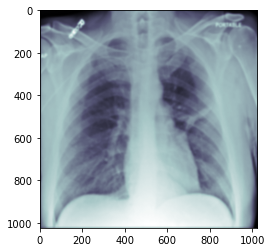

In [123]:
#gaussian blurring augmentation

my_idg = my_image_augmentation(all_df)
my_t_x, my_t_y = next(my_idg)

plt.imshow(my_t_x, cmap = 'bone')

In [124]:
train_data, val_data = create_splits(all_df)

Percent: 1


In [125]:
train_data.shape

(2070, 30)

In [126]:
train_data['pneumonia_class'].value_counts()

0    1035
1    1035
Name: pneumonia_class, dtype: int64

In [127]:
val_data.shape

(399, 30)

In [128]:
val_data['pneumonia_class'].value_counts()

0    395
1      4
Name: pneumonia_class, dtype: int64

In [129]:
print("Val Data range:")
print("Min: {0}".format(np.min(val_data['Patient Age'])))
print("Max: {0}".format(np.max(val_data['Patient Age'])))

Val Data range:
Min: 20
Max: 80


In [54]:
train_data.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class
75262,00018464_027.png,Pneumonia,27,18464,58,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
11374,00002998_001.png,No Finding,1,2998,57,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
105948,00028518_017.png,Infiltration|Pneumonia,17,28518,48,F,AP,3056,2544,0.139000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1
6489,00001738_004.png,No Finding,4,1738,46,M,PA,2048,2500,0.171000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
109127,00029659_001.png,No Finding,1,29659,35,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


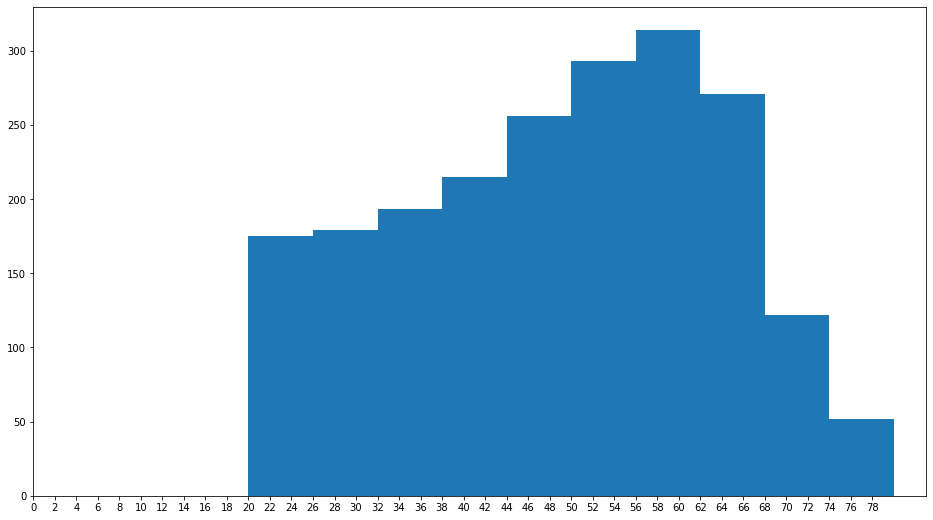

In [55]:
plt.figure(figsize=(16,9))
plt.hist(train_data['Patient Age'], 10)
plt.xticks(range(0, np.max(train_data['Patient Age']), 2))
plt.show()

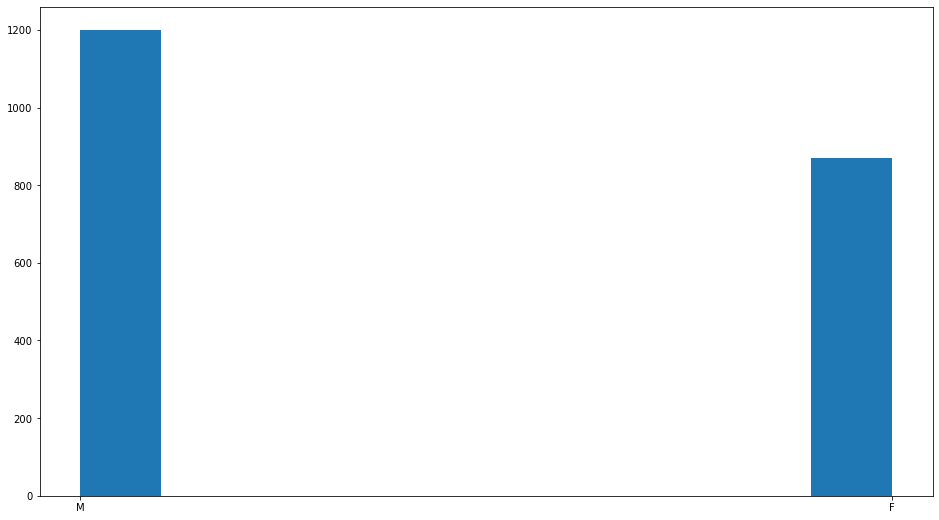

In [56]:
plt.figure(figsize=(16,9))
plt.hist(train_data['Patient Gender'])
plt.show()

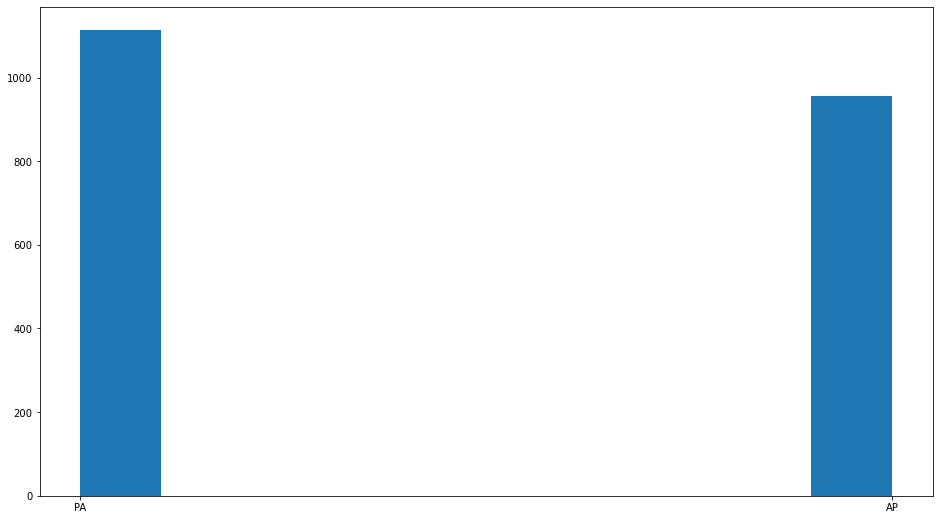

In [57]:
plt.figure(figsize=(16,9))
plt.hist(train_data['View Position'])
plt.show()

In [58]:
print("======================= VAL Plots=======================")

======================= VAL Plots=======================


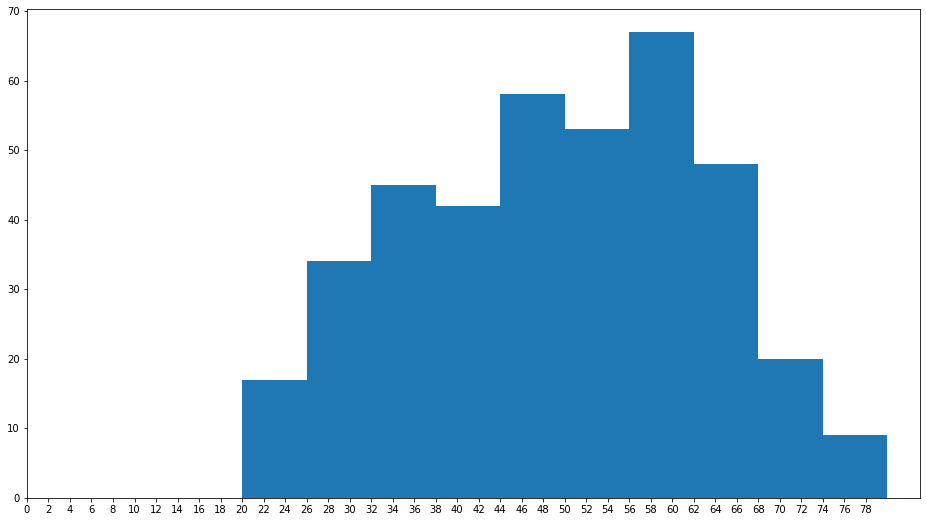

In [59]:
plt.figure(figsize=(16,9))
plt.hist(val_data['Patient Age'], 10)
plt.xticks(range(0, np.max(val_data['Patient Age']), 2))
plt.show()

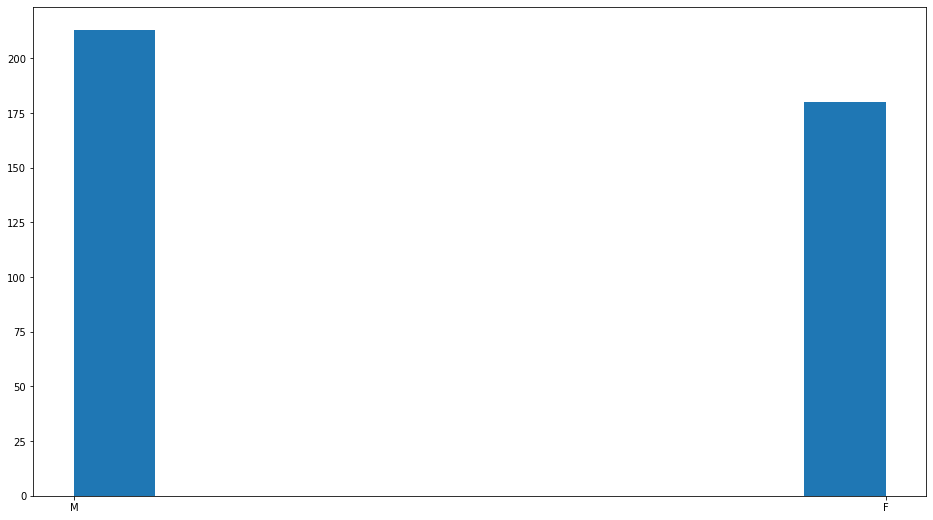

In [60]:
plt.figure(figsize=(16,9))
plt.hist(val_data['Patient Gender'])
plt.show()

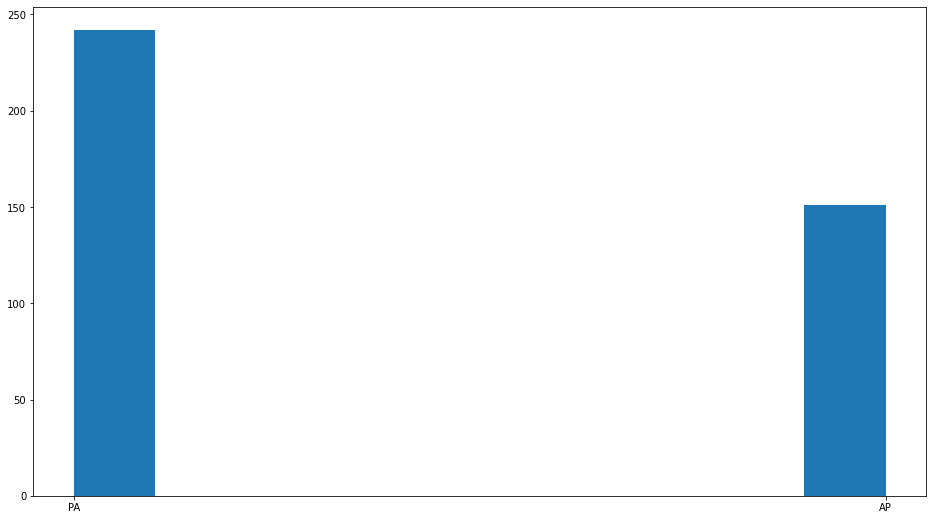

In [61]:
plt.figure(figsize=(16,9))
plt.hist(val_data['View Position'])
plt.show()

In [62]:
val_data.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class
56661,00014089_005.png,No Finding,5,14089,39,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
4193,00001142_000.png,Effusion,0,1142,51,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
106076,00028548_000.png,No Finding,0,28548,30,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
27676,00007197_000.png,No Finding,0,7197,46,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
91006,00022681_000.png,No Finding,0,22681,33,F,PA,2492,2748,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


In [53]:
## May want to pull a single large batch of random validation data for testing after each epoch:


val_gen = make_val_gen(val_data)

valX, valY = val_gen.next()



Found 1295 validated image filenames belonging to 2 classes.


In [54]:
train_gen = make_train_gen(train_data)

Found 2070 validated image filenames belonging to 2 classes.


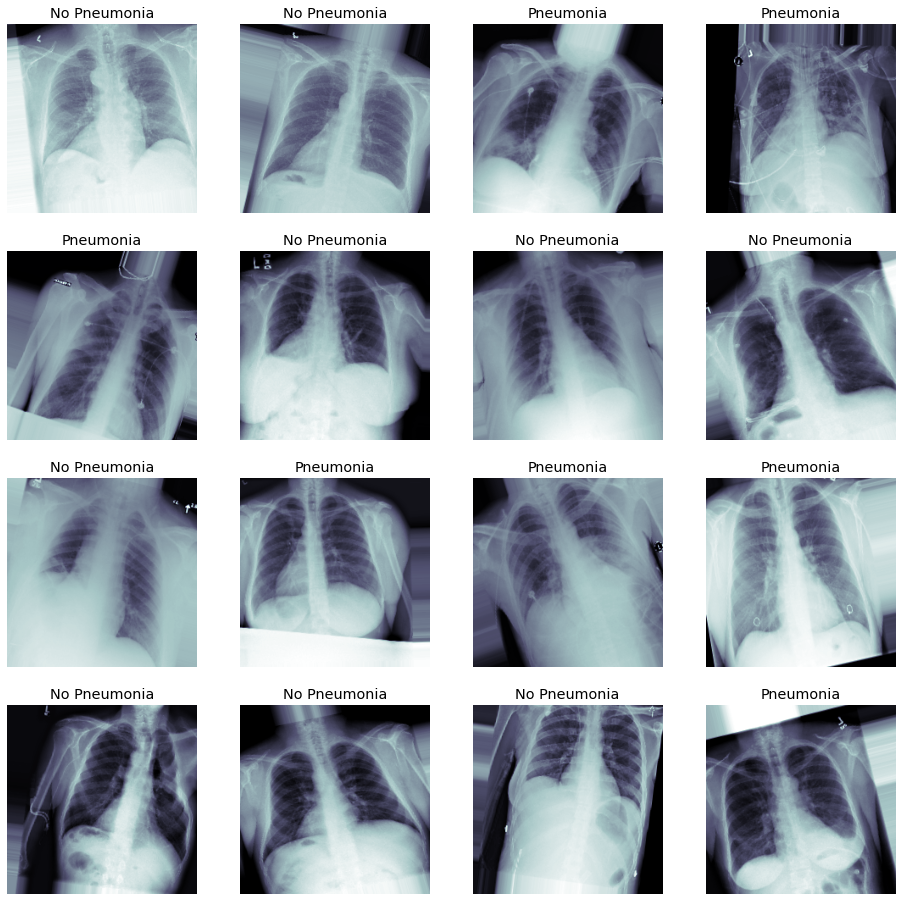

In [55]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation



t_x, t_y = next(train_gen)

train_xs.extend(t_x.ravel())



fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [56]:
def load_pretrained_model(vargs):
    
    
    #new_input = Input(shape=(IMG_SIZE[0],IMG_SIZE[1],3))
    #model = VGG16(weights='imagenet', include_top=False, input_tensor=new_input)
    model = VGG16(weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    print("VGG16 arch:")
    print(vgg_model.summary())
    # Todo
    
    return vgg_model


In [57]:
def build_my_model(vargs):
    
    my_model = Sequential()
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_model = load_pretrained_model(vargs)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    for i in range(17):
        vgg_model.layers[i].trainable = False
        
    my_model.add(vgg_model)
    
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())


    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.3))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))


    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    print("--------------------------------------")
    print("Our Model Arch:")
    print(my_model.summary())
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    optimizer = Adam(lr=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [58]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',#CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', #SAME_AS_METRIC_CHOSEN_ABOVE
                      mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [59]:
my_model = build_my_model(train_data)

VGG16 arch:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128

In [60]:
## train your model

# Todo


history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
130/130 [==============================] - 56s 428ms/step - loss: 0.7020 - binary_accuracy: 0.5362 - val_loss: 0.6869 - val_binary_accuracy: 0.5400
Epoch 2/30
130/130 [==============================] - 53s 405ms/step - loss: 0.6868 - binary_accuracy: 0.5599 - val_loss: 0.6943 - val_binary_accuracy: 0.5300
Epoch 3/30
130/130 [==============================] - 53s 410ms/step - loss: 0.6746 - binary_accuracy: 0.5870 - val_loss: 0.6256 - val_binary_accuracy: 0.6800
Epoch 4/30
130/130 [==============================] - 53s 407ms/step - loss: 0.6673 - binary_accuracy: 0.5942 - val_loss: 0.6947 - val_binary_accuracy: 0.5100
Epoch 5/30
130/130 [==============================] - 52s 403ms/step - loss: 0.6592 - binary_accuracy: 0.6159 - val_loss: 0.6401 - val_binary_accuracy: 0.6600
Epoch 6/30
130/130 [==============================] - 53s 406ms/step - loss: 0.6547 - binary_accuracy: 0.6261 - val_loss: 0.6296 - val_binary_accuracy: 0.6300
Epoch 7/30
130/130 [==========================

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [70]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
prob_pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 1s 10ms/step


In [71]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return thresholds

def plot_pr_curve(t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    # plot the precision-recall curves
    baseline = sum(t_y==1) / len(t_y)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.plot(recall, precision, marker='.', label='Algorithm')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return 

    fig = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500
    )
    
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0
    )
    
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')

    fig.show()
    
    
    return

## what other performance statistics do you want to include here besides AUC? 

    

def get_statistics(t_y, p_y, threshold):
    
    tn, fp, fn, tp = confusion_matrix(t_y, p_y).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1_score = (2 * precision * recall) / (precision + recall)
    
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    
    return [threshold, sensitivity, specificity, precision, recall, f1_score, accuracy]
    
# Todo
    
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

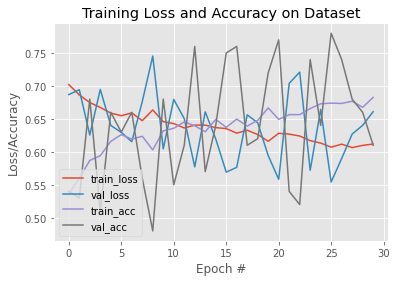

In [72]:
## plot figures

# Todo
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

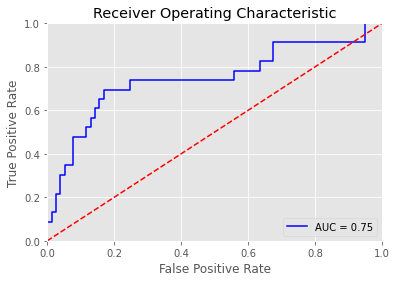

In [73]:
thresholds = plot_auc(valY, prob_pred_Y)

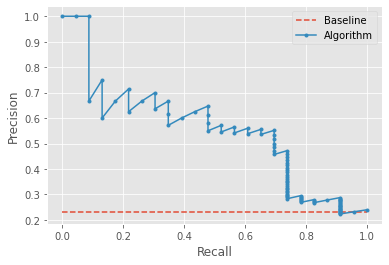

In [74]:
plot_pr_curve(valY, prob_pred_Y)

In [75]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
statistics = []

for threshold in np.arange(0.0, 1.0, 0.1):
    pred_Y = (prob_pred_Y >= threshold)
    statistics.append(get_statistics(valY, pred_Y, threshold))

df = pd.DataFrame(statistics,
                     columns=['Threshold', 'Sensitivity', 'Spec.', 'Precision', 'Recall', 'F1_score', 'Accuracy'])

df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars


,Threshold,Sensitivity,Spec.,Precision,Recall,F1_score,Accuracy
0,0.0,1.000000,0.000000,0.230000,1.000000,0.373984,0.23
1,0.1,1.000000,0.012987,0.232323,1.000000,0.377049,0.24
2,0.2,0.913043,0.155844,0.244186,0.913043,0.385321,0.33
3,0.3,0.826087,0.337662,0.271429,0.826087,0.408602,0.45
4,0.4,0.739130,0.597403,0.354167,0.739130,0.478873,0.63
5,0.5,0.695652,0.805195,0.516129,0.695652,0.592593,0.78
6,0.6,0.565217,0.870130,0.565217,0.565217,0.565217,0.80
7,0.7,0.304348,0.961039,0.700000,0.304348,0.424242,0.81
8,0.8,0.086957,0.987013,0.666667,0.086957,0.153846,0.78
9,0.9,0.000000,1.000000,NaN,0.000000,NaN,0.77


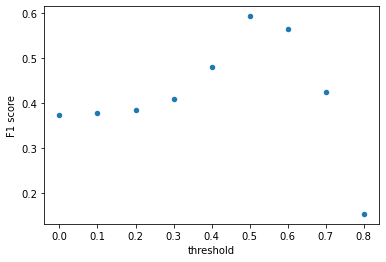

In [134]:
thresholds = np.arange(0.0, 1.0, 0.1)
f1s = [0.373984, 0.377049, 0.385321, 0.408602, 0.478873, 0.592593, 0.565217, 0.424242, 0.153846, np.NaN]

df_f1_thresholds = pd.DataFrame(zip(thresholds, f1s), columns=['threshold', 'F1 score'])
df_f1_thresholds.plot(kind='scatter', x='threshold', y='F1 score')

In [77]:
chosen_threshold = 0.6
pred_Y = (prob_pred_Y >= threshold)

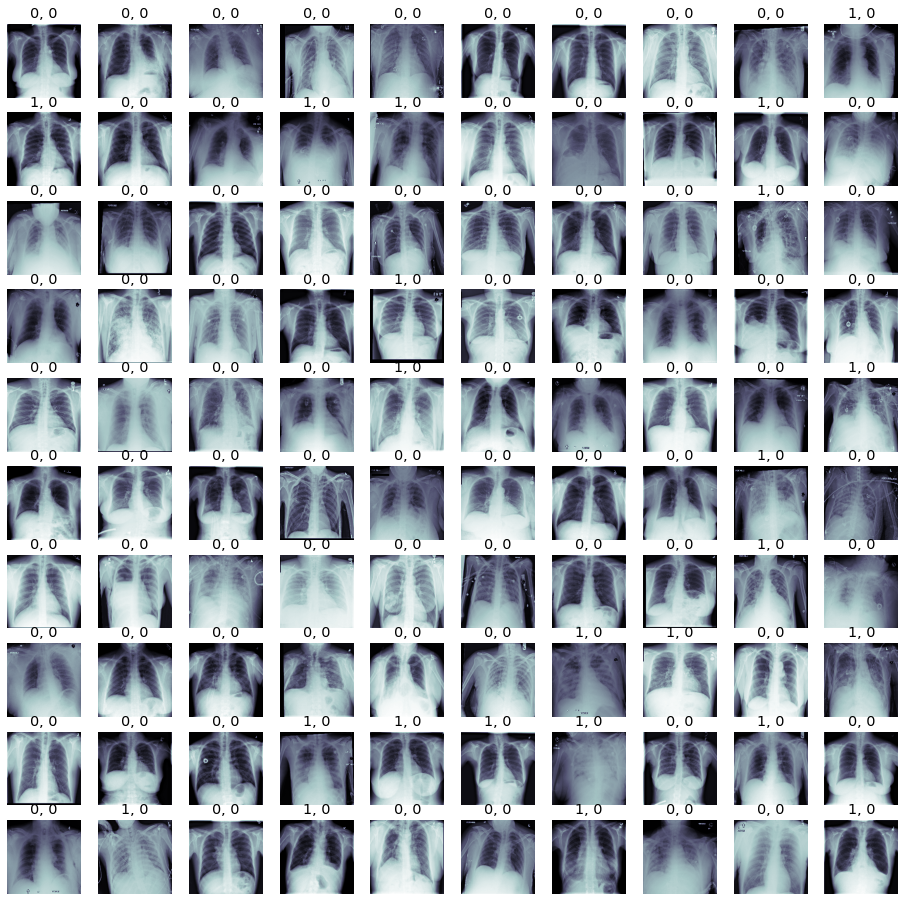

In [78]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):#this was testY instead of valY, I changed.
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > chosen_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > chosen_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [81]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
    